In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [3]:
pjme = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Measles/cameroon.csv', index_col=[0], parse_dates=[0])

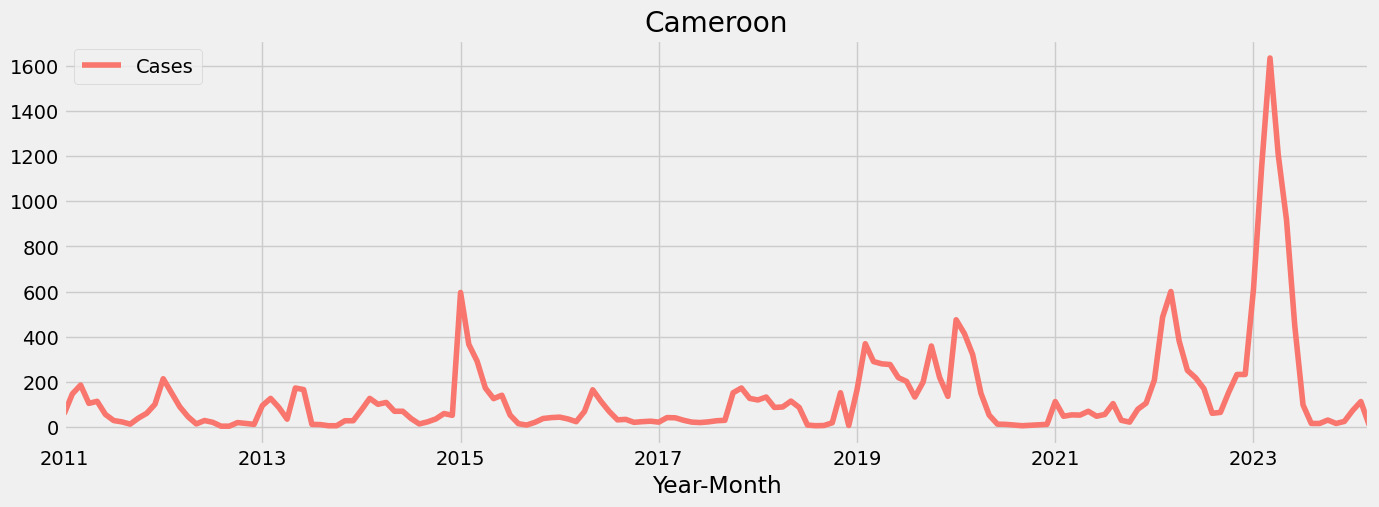

In [4]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(figsize=(15,5), color=color_pal[0], title='Cameroon')

In [5]:
split_date = '01-March-2023'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [6]:
len(pjme_test)

12

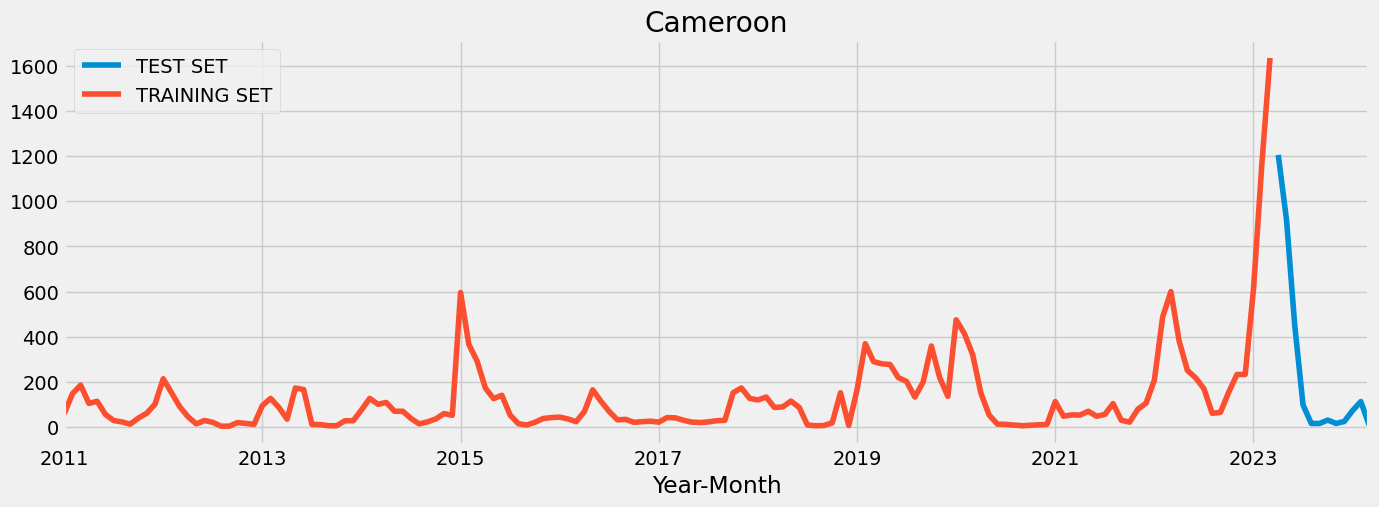

In [7]:
_ = pjme_test \
    .rename(columns={'Cases': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'Cases': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Cameroon')

In [8]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day

    X = df[['month','year','dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [9]:
X_train, y_train = create_features(pjme_train, label='Cases')
X_test, y_test = create_features(pjme_test, label='Cases')

In [10]:
reg = xgb.XGBRegressor(n_estimators=17, max_depth=7, eta=1.9, subsample=0.6, colsample_bytree=1)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=20,
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:181.49999	validation_1-rmse:340.59275
[1]	validation_0-rmse:125.83048	validation_1-rmse:731.06499
[2]	validation_0-rmse:93.96912	validation_1-rmse:1371.52882
[3]	validation_0-rmse:85.36719	validation_1-rmse:1326.07595
[4]	validation_0-rmse:67.57638	validation_1-rmse:1361.02636
[5]	validation_0-rmse:72.48548	validation_1-rmse:1314.15797
[6]	validation_0-rmse:58.31241	validation_1-rmse:1335.55105
[7]	validation_0-rmse:60.77020	validation_1-rmse:1338.58960


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:71.67578	validation_1-rmse:1357.61896
[9]	validation_0-rmse:72.10543	validation_1-rmse:1350.82929
[10]	validation_0-rmse:72.26562	validation_1-rmse:1335.26727
[11]	validation_0-rmse:56.18195	validation_1-rmse:1332.81890
[12]	validation_0-rmse:43.95443	validation_1-rmse:1332.29603
[13]	validation_0-rmse:45.83704	validation_1-rmse:1334.13389
[14]	validation_0-rmse:40.54075	validation_1-rmse:1329.20484
[15]	validation_0-rmse:30.47327	validation_1-rmse:1329.58085
[16]	validation_0-rmse:26.37375	validation_1-rmse:1328.24059


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eta=1.9, eval_metric=None, feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=17, n_jobs=None,
             num_parallel_tree=None, ...)

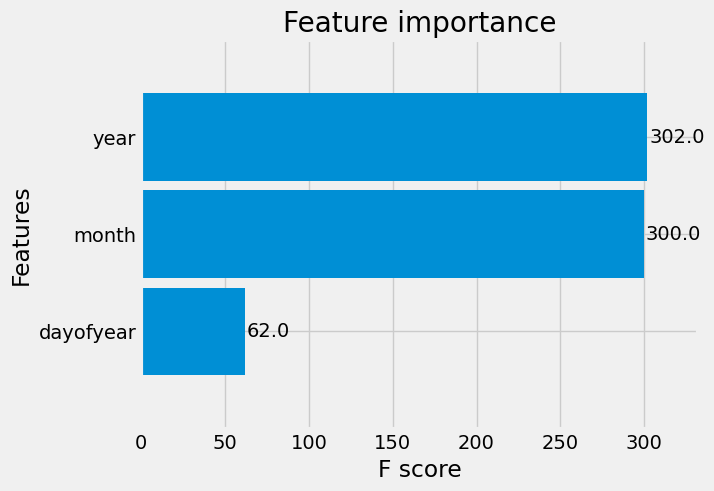

In [11]:
_ = plot_importance(reg, height=0.9)

In [12]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

In [13]:
pjme_test['MW_Prediction']

Year-Month
2023-04-01    366.247620
2023-05-01    366.247620
2023-06-01    213.478577
2023-07-01     64.328568
2023-08-01     64.328568
2023-09-01     64.328568
2023-10-01     64.328568
2023-11-01     64.328568
2023-12-01     64.328568
2024-01-01    113.728569
2024-02-01    549.032166
2024-03-01    366.247620
Name: MW_Prediction, dtype: float32

In [14]:
from sklearn.metrics import mean_squared_error
error = np.sqrt(mean_squared_error(pjme_test['Cases'],pjme_test['MW_Prediction']))
#print('Test RMSE: %.4f' % error)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(pjme_test['Cases'],pjme_test['MW_Prediction'])
#print("Mean Absolute Error (MAE):", mae)

from sklearn.metrics import mean_squared_log_error
msle = mean_squared_log_error(pjme_test['Cases'],pjme_test['MW_Prediction'])
#print("Mean Squared Logarithmic Error (MSLE):", msle)

from sklearn.metrics import mean_absolute_percentage_error
#print('Mean Absolute Percentage Error (MAPE):',mean_absolute_percentage_error(valid["Cases"],predictions))

print('RMSE: %.2f' % error)
def mean_absolute_percentage_error(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mape = mean_absolute_percentage_error(pjme_test['Cases'],pjme_test['MW_Prediction'])
print(f"MAPE: {mape:.2f}%")
print('MAE:  %.2f' % mae)
print('MSLE: %.2f' % msle)

RMSE: 340.59
MAPE: 483.20%
MAE:  225.78
MSLE: 2.12
